# Delta-Sigma ADC

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_deltasigma.py).This example demonstrates a first-order delta-sigma (ΔΣ) ADC, a popular architecture for high-resolution analog-to-digital conversion. The system uses oversampling and noise shaping to achieve high precision with a simple 1-bit quantizer.



## Delta-Sigma ADC Principle

A delta-sigma ADC works by:
1. **Oversampling** the input signal at a high frequency
2. Using a **1-bit quantizer** (comparator)
3. **Negative feedback** through a DAC to shape quantization noise
4. **Digital filtering** (FIR) to downsample and reconstruct the signal

The key advantage is that quantization noise is pushed to high frequencies (noise shaping), where it can be filtered out.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import (
    Integrator, Adder, Scope, Source, 
    SampleHold, DAC, Comparator, FIR
)
from pathsim.solvers import RKBS32

## System Parameters

We set the key parameters:
- **Clock frequency**: 100 Hz (oversampling rate)
- **Reference voltage**: 1.0 V
- **FIR filter**: 20 taps, cutoff at Fs/50

The input signal is a 1 Hz sine wave, so the oversampling ratio is 100.

In [5]:
v_ref = 1.0           # DAC reference
f_clk = 100           # Sampling frequency
T_clk = 1.0 / f_clk   # Sampling period

# Design FIR lowpass filter for decimation
fir_coeffs = firwin(20, f_clk/50, fs=f_clk)

## Block Diagram

We create the blocks for the delta-sigma modulator:
- `src`: Input signal (sine wave)
- `sub`: Subtractor (input - feedback)
- `itg`: Integrator (loop filter)
- `sah`: Sample & Hold
- `qtz`: Comparator (1-bit quantizer)
- `dac`: 1-bit DAC for feedback
- `lpf`: FIR lowpass filter for reconstruction

In [8]:
# Blocks that define the system
src = Source(lambda t: np.sin(2*np.pi*t))
sub = Adder("+-")
itg = Integrator() 
sah = SampleHold(T=T_clk, tau=T_clk*1e-3)
qtz = Comparator(span=[0, 1])
dac = DAC(n_bits=1, span=[-v_ref, v_ref], T=T_clk, tau=T_clk*2e-3)
lpf = FIR(coeffs=fir_coeffs, T=T_clk, tau=T_clk*2e-3)
sc1 = Scope(labels=["src", "qtz", "dac", "lpf"]) 
sc2 = Scope(labels=["itg", "sah"]) 

blocks = [src, sub, itg, sah, qtz, dac, lpf, sc1, sc2]

## Connections

The connections form the delta-sigma loop with digital filtering.

In [11]:
connections = [
    Connection(src, sub[0], sc1[0]),      # Source to subtractor and scope
    Connection(dac, sub[1], lpf, sc1[2]), # DAC feedback and to FIR filter
    Connection(sub, itg),                 # Difference to integrator
    Connection(itg, sah, sc2[0]),         # Integrator to S&H
    Connection(sah, qtz, sc2[1]),         # S&H to comparator
    Connection(qtz, dac[0], sc1[1]),      # Comparator to DAC
    Connection(lpf, sc1[3]),              # Filtered output
]

## Simulation

We use an adaptive solver (RKBS32) with a maximum timestep to handle the discrete-time sampling events properly.

In [14]:
# Simulation with adaptive solver
Sim = Simulation(
    blocks,
    connections,
    dt_max=T_clk*0.1,
    Solver=RKBS32
)

# Run simulation for 2 seconds
Sim.run(2)

2025-10-09 20:49:13,576 - INFO - LOGGING (log: True)
2025-10-09 20:49:13,577 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-09 20:49:13,577 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-09 20:49:13,578 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-09 20:49:13,578 - INFO - BLOCK (type: SampleHold, dynamic: False, events: 1)
2025-10-09 20:49:13,578 - INFO - BLOCK (type: Comparator, dynamic: False, events: 1)
2025-10-09 20:49:13,579 - INFO - BLOCK (type: DAC, dynamic: False, events: 1)
2025-10-09 20:49:13,579 - INFO - BLOCK (type: FIR, dynamic: False, events: 1)
2025-10-09 20:49:13,579 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-09 20:49:13,580 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-09 20:49:13,581 - INFO - GRAPH (size: 9, alg. depth: 2, loop depth: 0, runtime: 0.088ms)
2025-10-09 20:49:13,581 - INFO - STARTING -> TRANSIENT (Duration: 2.00s)
2025-10-09 20:49:13,581 - INFO - TRANSIENT:   

{'total_steps': 2402,
 'successful_steps': 2401,
 'runtime_ms': 257.8220999566838}

## Results

The plots show:
1. **src** (blue): Original analog input signal
2. **qtz** (orange): 1-bit quantizer output (high-frequency switching)
3. **dac** (green): 1-bit DAC feedback signal
4. **lpf** (red): Reconstructed signal after FIR filtering

Notice how the 1-bit stream encodes the analog signal, and the FIR filter successfully reconstructs it.

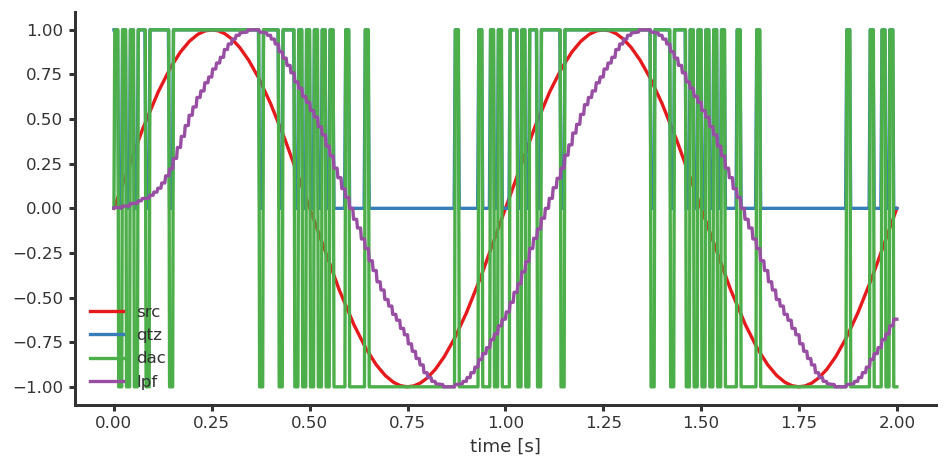

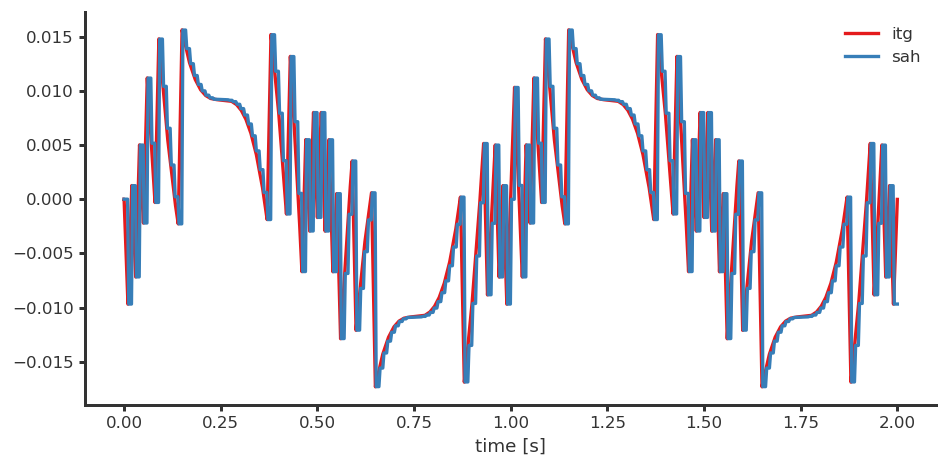

In [17]:
Sim.plot()
plt.show()